In [1]:
import numpy as np
from EM import EM
from plot import plot
import matplotlib.pyplot as plt

In [2]:
signal_name = 'bun'
treatment_names = {}
treatment_names['dialysis'] = ['dialysis'] 
treatment_names['diuretic'] = ['eplerenone_dose', 'amiloride_dose', 'hydrochlorothiazide_dose',
'spironolactone_dose', 'triamterene_dose', 'chlorothiazide_dose', 'indapamide_dose', 'torsemide_dose', 
'acetazolamide_dose', 'mannitol_dose']
treatment_names['drugs_increase'] = ['vancomycin_dose',
 'furosemide_dose',
 'carbamazepine_dose',
 'rifampin_dose',
 'hydrochlorothiazide_dose',
 'spironolactone_dose',
 'methotrexate_dose',
 'chlorothiazide_dose',
 'methyclothiazide_dose',
 'amphotericin_b_ambisome_dose',
 'amphotericin_b_fungizone_dose',
 'cefazolin_dose',
 'ceftriaxone_dose',
 'ceftazidime_dose',
 'cefuroxime_dose',
 'cefotaxime_dose']

chronic_keywords = ['chronic_kidney', 'kidney_cancer', 'renal', 'esrd', 'heart_failure', 'liver',
                    'heart_attack']

demographic_names = []

In [3]:
# EM Setting
num_past_effects = 2
training_pct = .8
single_effect = False

In [4]:
data = np.load('../Data/'+signal_name+'_preprocessed_data.npz')

In [122]:
patient_index = 232
y_mtx = data['y_mtx'][patient_index, :]
X_mtx = data['X_mtx'][patient_index, :, :]
c_mtx = data['c_mtx'][patient_index, :]
X_prev_mtx = data['X_prev_mtx'][patient_index, :, :]
y_mtx = y_mtx[np.newaxis, :]
X_mtx = X_mtx[np.newaxis, :, :]
c_mtx = c_mtx[np.newaxis, :]
X_prev_mtx = X_prev_mtx[np.newaxis, :, :]

In [128]:
%%time
em = EM(data['y_mtx'], data['X_mtx'], data['c_mtx'], num_past_effects, K=0, train_pct=training_pct, X_prev_given=True,
        X_prev = data['X_prev_mtx'], single_effect=single_effect)
#em = EM(y_mtx, X_mtx, c_mtx, num_past_effects, K=0, train_pct=training_pct, X_prev_given=True,
#        X_prev = X_prev_mtx, single_effect=single_effect)
em.run_EM(2000)

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
59 iterations before params converge
CPU times: user 3min 17s, sys: 120 ms, total: 3min 17s
Wall time: 3min 17s


In [129]:
for i, treatment in enumerate(treatment_names.keys()):
    print('Coefficient for {}: {}'.format(treatment, em.A[:, i]))
static_types = chronic_keywords + demographic_names
for j, static in enumerate(static_types):
    print('Coefficient for {}: {}'.format(static, em.b[j]))
print('initial state mean: {}'.format(em.init_z))
print('initial state variance: {}'.format(em.sigma_0))
print('transition noise: {}'.format(em.sigma_1))
print('observation noise: {}'.format(em.sigma_2))

Coefficient for dialysis: [-12.73600606 -10.26637858]
Coefficient for diuretic: [-0.48169377 -1.29906573]
Coefficient for drugs_increase: [-2.49814751 -2.04331816]
Coefficient for chronic_kidney: 13.34940698843989
Coefficient for kidney_cancer: 7.116235147020342
Coefficient for renal: 11.295012255086368
Coefficient for esrd: 14.322354545836648
Coefficient for heart_failure: 3.3280429451387117
Coefficient for liver: -2.1557794531815127
Coefficient for heart_attack: -6.478613696340371
initial state mean: 27.40662053944892
initial state variance: 0.0067733160756222295
transition noise: 57.63390610123125
observation noise: 175.16017320564674


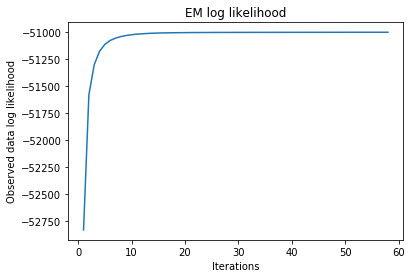

In [130]:
plt.plot([i for i in range(1, len(em.obs_log_lik))], em.obs_log_lik[1:])
plt.xlabel('Iterations')
plt.ylabel('Observed data log likelihood')
plt.title('EM log likelihood')
plt.show()

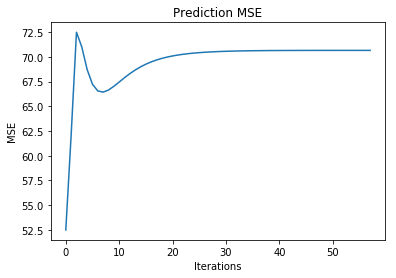

In [131]:
plt.plot([i for i in range(len(em.mse))], em.mse)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('Prediction MSE')
plt.show()

In [20]:
converge = np.array(em.sos)
initial = np.array(a)

In [26]:
diff = converge - initial

In [132]:
np.argsort(diff)[-30:]

array([1647,   34,  457, 1939, 2213, 1244,  880,   57,  703, 1440, 1203,
       1552,  474, 2093, 1035,  382, 1858,  577,  600, 2139, 1857,  160,
       1630, 1501,  346, 2171,  973, 2259,  424,  727])

Patient 34


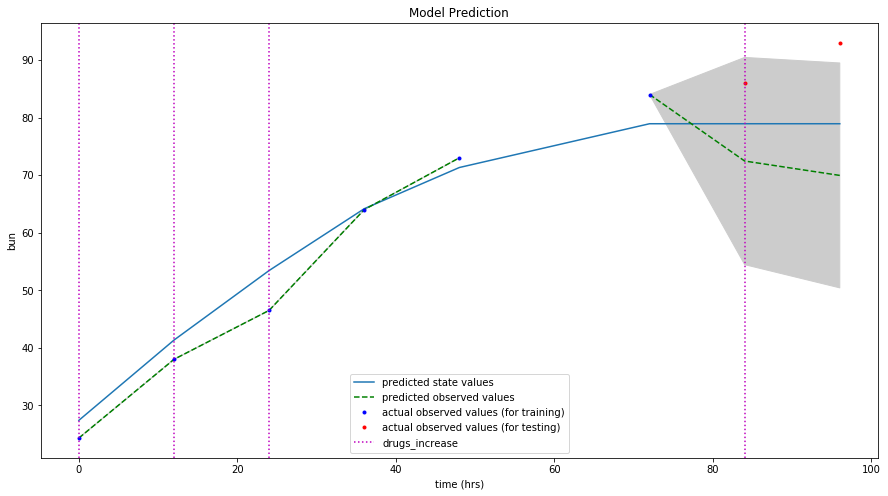

In [143]:
random_patients = [34] #np.random.randint(0, em.y.shape[0], 50)
for i in random_patients:
    plot(em, i, 12, signal_name, treatment_types=list(treatment_names.keys()))

### Analysis
Changes
* Only select patients with at least 4 training observations (total of 1821)

On real data
* Issues:
    * treatments coefficients are negative while they should be positive
        * changing initialization doesn't seem to help as model converges in bad local min, and most directions still don't change
    * observation noise is bigger than transition noise
    * run time is long, each iteration takes 4s, M step takes 2.5s, loglik takes 1s
* Reasons:
    * The increasing effects of treatments are not pronouced in the data (see Source Data Analysis)
        * it makes sense that nsaid and aspirin shows small number close to zero since their effects are 50-50.
        * transfusion platelet should be more negative than others, also makes sense.
        * the first number for plasma is a very negative number, but should be close to zero
        * anticoagulant are more negative than platelet, but should be more similar
    * bad noise estimation is expected, specifically underestimated initial state variance and overestimated observational noise 
    
On simulation
* Issues
    * b seems to be harder to identify correctly compared to A (sensitive to initialization)
    * estimated sigma 0 and sigma 2 are very different from the true value (not sensitive to initialization)
        * underestimate sigma 0, overestimate sigma 2
* Reasons
   